<a href="https://colab.research.google.com/github/NyashaNziramasanga/Masters-of-Computer-Science/blob/master/2021-Semester-2/COMP8715-heuristic-optimisation/Week5-feature-normalisation/practical/COMP2712_2021_Practical03_Checkpoint05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP2712 Practical03, Checkpoint05
## Exploring feature reduction with PCA with ML


For further explanation of the feature reduction please review the notebook [COMP2712 Exploring feature reduction wtih PCA](https://colab.research.google.com/drive/1rOL7B6PGb-bovZ7z26K0daqTCzErZJpX?usp=sharing)

Adpated from [Principal Component Analysis (PCA) in Python](https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python)


In [ ]:
!pip install pycm

In [ ]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#scikit for machine learning reporting
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import pycm

# timing 
import time


Load the data from the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) from the UCI ML database


In [ ]:
bc = load_breast_cancer()
bc_data = bc.data 
print('Data shape  : {0}'.format(bc_data.shape))
bc_labels = bc.target
print('Target shape: {0}'.format(bc_labels.shape))
labels = np.reshape(bc_labels,(569,1))
final_bc_data = np.concatenate([bc_data,labels],axis=1)

bc_dataset = pd.DataFrame(final_bc_data)


Data shape  : (569, 30)
Target shape: (569,)


In [ ]:
features = bc.feature_names
features_labels = np.append(features,'label')
bc_dataset.columns = features_labels
y_int = bc_dataset['label'] # integer encoding
bc_dataset['label'].replace(0, 'Benign',inplace=True)
bc_dataset['label'].replace(1, 'Malignant',inplace=True)

In [ ]:
print('One Hot Encoding')
y_oh = pd.get_dummies(bc_dataset['label'])
y_oh.sample(7)

One Hot Encoding


,Benign,Malignant
31,1,0
451,1,0
418,0,1
267,0,1
545,0,1
428,0,1
64,1,0


## Split into train and test data

Before we can calculat PCA we need to split into train and test data, otherwise we can contaminate the training data with test data throug the normalisation and PCA transformations!!

In [ ]:
x = bc_dataset.loc[:, features].values

x_train, x_test, y_train, y_test = train_test_split(x, y_oh, test_size=0.3,
                                                    random_state=0, stratify=y_int)

## Standardise the Breast Cancer data for PCA

In [ ]:
std_bc = StandardScaler()
std_bc.fit(x_train)
x_train_std = std_bc.transform(x_train)

#x_train_std = StandardScaler().fit_transform(x_train) # normalizing the features
print(np.mean(x_train),np.std(x_train))
print('after')
print(np.mean(x_train_std),np.std(x_train_std))

feat_cols = features #['feature'+str(i) for i in range(x.shape[1])]
normalised_bc = pd.DataFrame(x_train_std,columns=feat_cols)
normalised_bc.describe()

61.73109520657454 229.13797584049445
after
-1.0235623999224224e-16 1.0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02
mean,-3.356611e-15,-7.134159e-16,6.067174e-15,1.707177e-16,-3.616593e-15,4.198205e-16,1.351515e-16,3.140983e-16,-6.243958e-16,2.520318e-15,8.019827e-16,-1.689045e-15,2.394790e-16,1.771336e-17,3.068456e-17,-6.853814e-16,3.207931e-16,2.392001e-17,2.802058e-16,1.472301e-15,1.183726e-15,5.111768e-16,-9.362974e-16,-6.164806e-16,-3.393154e-15,-7.425663e-16,8.044235e-16,2.989652e-16,-1.013846e-15,-1.231845e-15
std,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00
min,-1.772565e+00,-2.229153e+00,-1.759502e+00,-1.332476e+00,-3.117028e+00,-1.593253e+00,-1.132924e+00,-1.246069e+00,-2.747421e+00,-1.805583e+00,-1.008329e+00,-1.567298e+00,-9.871191e-01,-6.912017e-01,-1.405336e+00,-1.340399e+00,-1.183020e+00,-1.931089e+00,-1.320956e+00,-1.229659e+00,-1.540448e+00,-2.241442e+00,-1.541472e+00,-1.132190e+00,-2.229011e+00,-1.401592e+00,-1.322238e+00,-1.725441e+00,-2.179549e+00,-1.607049e+00
25%,-7.066824e-01,-7.142287e-01,-7.140949e-01,-6.763902e-01,-7.523932e-01,-7.655281e-01,-7.617353e-01,-7.352043e-01,-6.776842e-01,-7.140944e-01,-6.149406e-01,-7.050381e-01,-6.055483e-01,-4.684366e-01,-6.217642e-01,-7.021123e-01,-6.233905e-01,-7.090729e-01,-6.483102e-01,-6.337770e-01,-6.901926e-01,-7.456861e-01,-6.994730e-01,-6.431137e-01,-7.092987e-01,-6.759174e-01,-7.524327e-01,-7.569289e-01,-6.413180e-01,-6.920285e-01
50%,-2.430448e-01,-9.243594e-02,-2.365411e-01,-3.108585e-01,-1.862754e-02,-2.214819e-01,-3.583496e-01,-4.151912e-01,-7.242754e-02,-2.054394e-01,-3.005256e-01,-1.547445e-01,-2.786729e-01,-3.311227e-01,-2.551359e-01,-2.785809e-01,-2.090052e-01,-1.317316e-01,-2.194179e-01,-2.306401e-01,-2.683335e-01,-5.610055e-02,-2.753887e-01,-3.452303e-01,-7.745860e-02,-2.515780e-01,-2.119169e-01,-2.285606e-01,-1.096902e-01,-2.553490e-01
75%,4.610488e-01,6.055426e-01,4.796393e-01,3.508681e-01,6.717009e-01,4.839548e-01,5.542113e-01,6.505662e-01,5.634164e-01,4.572250e-01,2.603768e-01,4.872417e-01,2.035657e-01,9.556630e-02,3.681402e-01,4.092065e-01,4.242725e-01,4.943795e-01,3.262285e-01,3.536007e-01,5.238014e-01,6.673855e-01,5.292991e-01,3.531534e-01,6.126207e-01,5.197455e-01,5.444880e-01,7.014849e-01,4.753056e-01,4.439273e-01
max,3.870962e+00,4.702577e+00,3.876134e+00,5.080081e+00,3.335371e+00,4.535633e+00,3.663370e+00,3.615436e+00,4.593518e+00,4.903011e+00,8.598940e+00,4.946144e+00,9.019773e+00,1.035162e+01,7.615923e+00,6.350343e+00,1.014569e+01,4.728975e+00,6.948445e+00,7.856937e+00,4.049338e+00,3.569598e+00,4.237649e+00,5.854073e+00,3.983900e+00,4.351215e+00,4.789533e+00,2.645133e+00,6.149149e+00,4.999954e+00


Apply PCA from the `from sklearn.decomposition import PCA`.  Very important to to remember to calculate the PCA transform on the **training** data.  The PCA transform is part of the modelling pipeline and so we do not want data leakage from the testing data.


In [ ]:
pca_bc = PCA()
# fit the PCA transform on the ** training data **
x_train_std_pca = pca_bc.fit_transform(x_train_std)

# convert into a pandas dataframe
pc_cols = ['PC '+str(i+1) for i in range(x.shape[1])]
x_train_std_pca_df = pd.DataFrame(data = x_train_std_pca, columns = pc_cols)

<Figure size 432x288 with 0 Axes>

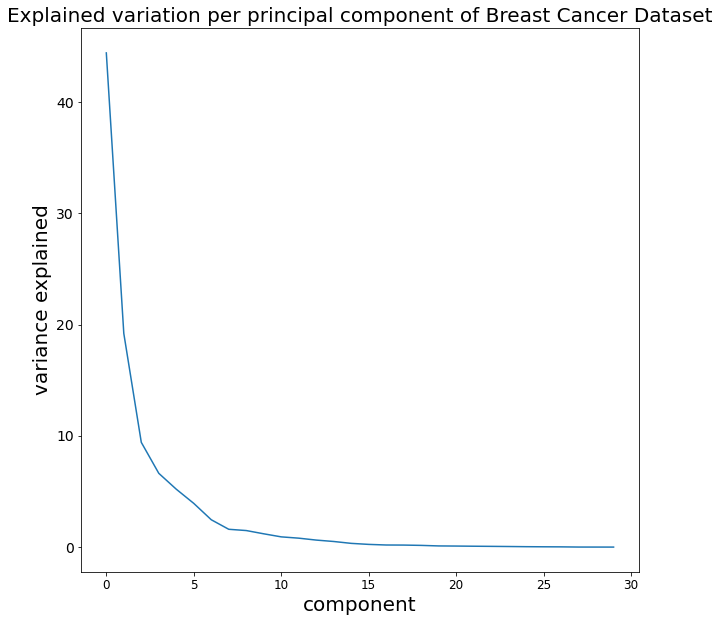

In [ ]:
#print('Explained variation per PC: {}'.format(pca_bc.explained_variance_ratio_))

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('component',fontsize=20)
plt.ylabel('variance explained',fontsize=20)
plt.title("Explained variation per principal component of Breast Cancer Dataset",fontsize=20)

plt.plot(pca_bc.explained_variance_ratio_*100);

## Examine the contribution of Features to Components

From the below output, you can observe that the principal component 1 holds 44% of the information while the principal component 2 holds only 19% of the information. Also, the other point to note is that while projecting thirty-dimensional data to a two-dimensional data, 36.8% information was lost.


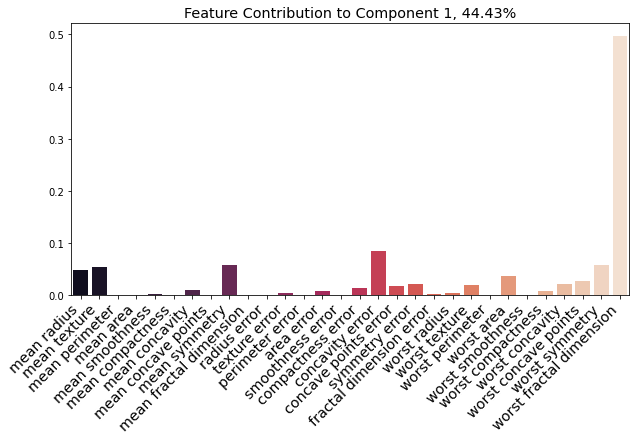

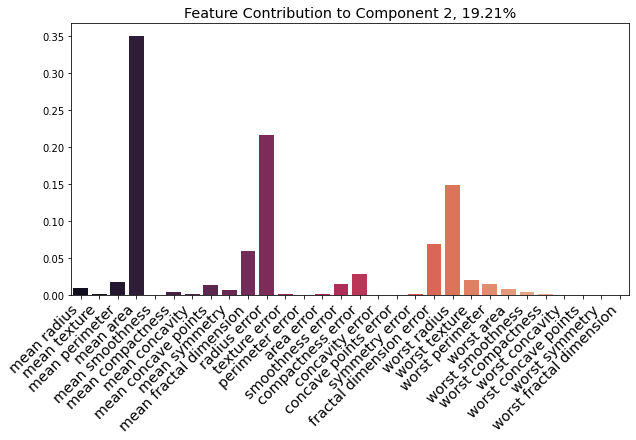

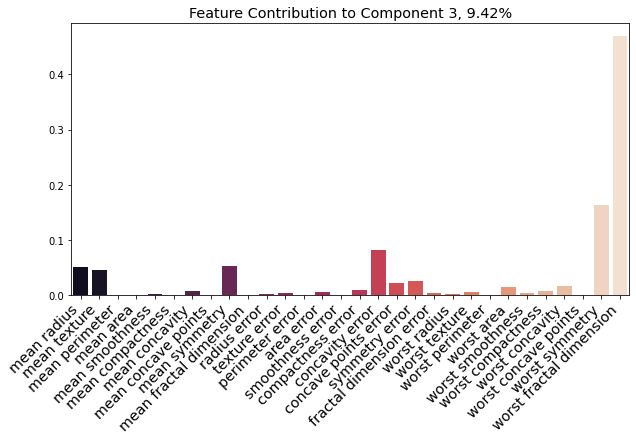

In [ ]:
def plot_contrib(comp, explained, ci):
  plt.figure(figsize=(10,5))
  ch = sns.barplot(x=features, y=comp[:,ci]**2, palette="rocket")
  ch.set_xticklabels(ch.get_xticklabels(), rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
  ch.set_title('Feature Contribution to Component {0}, {1}%'.format(ci+1,np.round(explained[ci]*100,2)),fontsize='x-large')

  return ch

plot_contrib(pca_bc.components_,pca_bc.explained_variance_ratio_,0)
plot_contrib(pca_bc.components_,pca_bc.explained_variance_ratio_,1)
plot_contrib(pca_bc.components_,pca_bc.explained_variance_ratio_,2)

## Plot components

From the graph below, you can observe that the two classes benign and malignant, when projected to a two-dimensional space, can be linearly separable up to some extent. Other observations can be that the benign class is spread out as compared to the malignant class.

<Figure size 432x288 with 0 Axes>

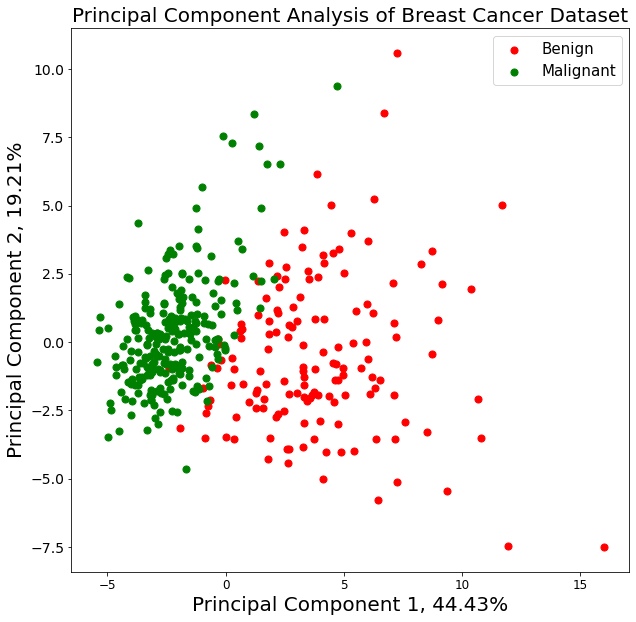

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
pc1_explained = np.round(pca_bc.explained_variance_ratio_[0]*100,2)
pc2_explained = np.round(pca_bc.explained_variance_ratio_[1]*100,2)
plt.xlabel('Principal Component 1, {0}%'.format(pc1_explained),fontsize=20)
plt.ylabel('Principal Component 2, {0}%'.format(pc2_explained),fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = ['Benign', 'Malignant']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = y_train[target].values == 1 # one hot encoding
    plt.scatter(x_train_std_pca_df.loc[indicesToKeep, 'PC 1']
               , x_train_std_pca_df.loc[indicesToKeep, 'PC 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

## Checkpont05: How many components to keep?

At this point we can decide to keep all the nicely uncorrelated components or we can reduce the number of features by choosing only a few of the top components to train our classifier.  We could try just the top 2, or any other number up to the full component set.

Another, less artibitary way is to retain components that account for a certain percentage of the variance, say 90%.  It might be that additional components are not adding value (but that is debatable).

In the below set `retain_what` to
- `by_number`: to specify the number of components to retain, adjust `n_comp_retain`
- `by_percentage`: to retain components based on percentage, adjust `n_comp_variance`
- otherwise we will retain all components

In [ ]:
# choose how to retain the top components
retain_what = 'all' # choose from 'all', 'by_number', 'by_variance'
n_comp_retain = 2 # 2 would mean the top two components (as sorted by contribution to variance)
n_comp_variance = 0.9 # 0.9 would mean retaining 90% of the variance and the actual number of components depends on data

if (retain_what == 'by_number'):
  # retain by the number of components
  n_comp_label = 'retaining top {} components'.format(n_comp_retain)
  x_train_std_pca_retain = x_train_std_pca[:,0:n_comp_retain]
elif (retain_what == 'by_variance'):
  # retain by the variance
  retain_index = pca_bc.explained_variance_ratio_.cumsum() <= n_comp_variance
  x_train_std_pca_retain = x_train_std_pca[:,retain_index]
  n_comp_retain = np.shape(x_train_std_pca_retain)[1]
  n_comp_label = 'retaining {:.2f}% varaince (n = {})'.format(n_comp_variance*100,n_comp_retain)
else:
  n_comp_label = 'retaining all components'
  x_train_std_pca_retain = x_train_std_pca
  n_comp_retain = np.shape(x_train_std_pca)[1]


print(n_comp_label)

### Now apply the transformations to the test data
x_test_std = std_bc.transform(x_test)
x_test_std_pca = pca_bc.fit_transform(x_test_std)
x_test_std_pca_retain = x_test_std_pca[:,0:n_comp_retain]


retaining all components


## Now let's train the model with the normalised, PCA'd data!


### Set up the Model

Setting up the model is where we can change settings and evaluate the affect on performance.  You can change settings such as
- `hidden_layer_sizes`: fewer nodes means less to optimize and quicker training, but too few nodes cannot model more complex problems.  How does it go with 1, 2, 3, 5, 10, more?
- `max_iter`: the number of iterations to train for.  Too many will take too long, but too few and the MLP may stop before it converges.  What's the smallest max_iter to get 'good' performance?

Have a look at the [documentation for the MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to see what the different parameters do to the learning.



In [ ]:
# Importing our model
from sklearn.neural_network import MLPClassifier

hidden_layer_size = 10
activation_fcn = 'relu' # {identity, logistic, tanh, relu}, default=’relu’
max_iter = 1000

# model initialization
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_size), activation=activation_fcn, max_iter=max_iter, alpha=0.01, #try change hidden layer, or max_iter
                     solver='sgd', verbose=1,  random_state=None) #try verbose=0 to train with out logging

tic = time.perf_counter()

# train our model
h = mlp.fit(x_train_std_pca_retain,y_train)

toc = time.perf_counter()
elapsed_time = toc - tic
print('\nTraining took {:0.4f} seconds'.format(elapsed_time))



Iteration 1, loss = 1.87104704
Iteration 2, loss = 1.85401861
Iteration 3, loss = 1.82910311
Iteration 4, loss = 1.79731905
Iteration 5, loss = 1.76069752
Iteration 6, loss = 1.72134890
Iteration 7, loss = 1.67963341
Iteration 8, loss = 1.63682796
Iteration 9, loss = 1.59457141
Iteration 10, loss = 1.55186297
Iteration 11, loss = 1.51023222
Iteration 12, loss = 1.47070870
Iteration 13, loss = 1.43098059
Iteration 14, loss = 1.39351688
Iteration 15, loss = 1.35788516
Iteration 16, loss = 1.32262832
Iteration 17, loss = 1.29037014
Iteration 18, loss = 1.25905172
Iteration 19, loss = 1.22859843
Iteration 20, loss = 1.20014337
Iteration 21, loss = 1.17251044
Iteration 22, loss = 1.14595887
Iteration 23, loss = 1.12152799
Iteration 24, loss = 1.09777418
Iteration 25, loss = 1.07552417
Iteration 26, loss = 1.05338573
Iteration 27, loss = 1.03215226
Iteration 28, loss = 1.01198894
Iteration 29, loss = 0.99258244
Iteration 30, loss = 0.97344216
Iteration 31, loss = 0.95533587
Iteration 32, los

### Plot a loss curve
The loss curve shows the history of how the training progressed.

In [ ]:
mlp.n_iter_

677

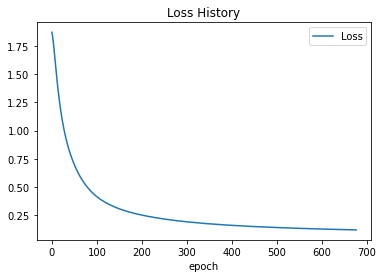

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.loss_curve_)
plt.title('Loss History')
plt.xlabel('epoch')
plt.legend(['Loss'])

## Test out the new model
The ouput from the `predict` function will set outputs of the MLP that are above 0.5 to 1 and below 0.5 to 0.  However, every now and then (especially if the class have not been separated well) there will be more than one class with a value about 0.5!  This results in two classes have a value of one, which is not really want we want for our classification (but sometimes it makes senses...sometimes).

The MLP has another function called `predict_proba` that returns the 'Probability Estimates' for the prediction.  We can then select the maximum of those probability estimates as the predicted class.

It can also be informative to compare the probability estimates for a prediction of an example to gauge the 'confidence' of a prediction. For example, an output of `[99 9 0]` is a more confident prediction than `[65 50 30]`.

In [ ]:
y_prob = mlp.predict_proba(x_test_std_pca_retain)

print('Probabilities (*100)')
print((y_prob[0:10,:]*100).astype(int))
print('Predictions (maximum for the row set 1, others zero)')
y_pred = y_prob
y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
print(y_pred[0:10,:])

Probabilities (*100)
[[99  0]
 [ 0 99]
 [99  0]
 [84 10]
 [99  0]
 [ 1 99]
 [99  0]
 [99  0]
 [95 18]
 [99  1]]
Predictions (maximum for the row set 1, others zero)
[[1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


### Evaluate the predictions


Predictions
[0 1 0 0 0 1 0 0 0 0]
Acutal
[0 0 0 1 0 1 0 0 0 0]

accuracy is  0.9122807017543859
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        64
           1       0.93      0.93      0.93       107

    accuracy                           0.91       171
   macro avg       0.91      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171

f1 score: 0.912
Bookmaker Informedness
Bookmaker: 0.816
Per Class: [0.8158586448598131, 0.8158586448598131]

[[57  7]
 [ 8 99]]


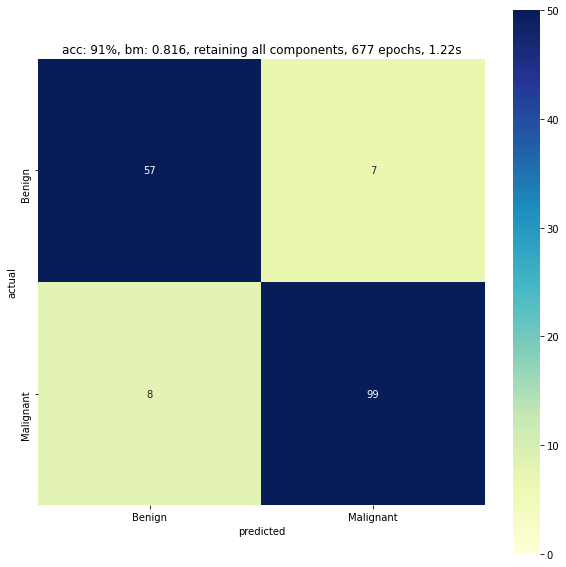

In [ ]:
def bookmaker(test_labels, y_pred):
  # calculate bm over classes using the pycm library
  cm = pycm.ConfusionMatrix(actual_vector=test_labels,predict_vector=y_pred)
  bmclass = list(cm.BM.values())

  # now calculate bias and the overall bookmaker
  cm = confusion_matrix(test_labels, y_pred)
  bias = np.sum(cm,axis=0) / np.sum(cm)

  bm = np.sum(bmclass*bias)
  
  return bm, bmclass


y_test_max = y_test.values.argmax(axis=1).astype(int)
y_pred_max = y_pred.argmax(axis=1).astype(int)

print('Predictions')
print(np.transpose(y_pred_max[0:10]))
print('Acutal')
print(np.transpose(y_test_max[0:10]))


print()
acc = accuracy_score(y_test_max, y_pred_max)
print('accuracy is ',acc) # Print accuracy score

cr = classification_report(y_test_max,y_pred_max)
print(cr)
f1 = f1_score(y_test_max, y_pred_max,average='weighted')

print('f1 score: {:.3f}'.format(f1))

print('Bookmaker Informedness')
bm, bmclass = bookmaker(y_test_max, y_pred_max)
print('Bookmaker: {:.3f}'.format(bm))
print('Per Class: {}'.format(bmclass))

# Produce a Confusion Matrix to visualise more easily where errors and confusion occur in the classification of the digits.
cm = confusion_matrix(y_test_max, y_pred_max)
print()
print(cm)

class_labels = ['Benign','Malignant']
df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)
fig, ax1 = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=50,fmt='d')
ax1.set_title('acc: {:.0f}%, bm: {:.3f}, {}, {} epochs, {:0.2f}s'.format(acc*100,bm,n_comp_label,mlp.n_iter_,elapsed_time));
ax1.set_xlabel('predicted')
ax1.set_ylabel('actual');